## GEOCODING: API call, or merge?

In [3]:
import pandas as pd
import geopandas as gpd
import json
from pandas import json_normalize
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
from requests.structures import CaseInsensitiveDict


#GPEtags = pd.read_csv("20species_GPEtags.csv", sep = ";")

In [2]:
gdf = gpd.read_file("shapefiles/Geo_tags_test.shp")

In [3]:
gdf = gdf.rename(columns = {'Country_co' : 'txt_mentions', 'scientific' : 'sci_name'})

In [58]:
world = gpd.read_file("shapefiles/World_Countries__Generalized_.shp")

In [60]:
world['COUNTRY'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       'Azerbaijan', 'Azores', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bolivia', 'Bonaire', 'Bosnia and Herzegovina',
       'Botswana', 'Bouvet Island', 'Brazil',
       'British Indian Ocean Territory', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Canarias',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Christmas Island', 'Cocos Islands', 'Colombia',
       'Comoros', 'Congo', 'Congo DRC', 'Cook Islands', 'Costa Rica',
       "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican 

In [5]:
# Read in the full dataframe with gpe info 
gpe = pd.read_csv("csv/speciesinfo_gpetags.csv", sep = ";")

In [63]:
# Create an empty list for storing the json responses
locs = []

# Loop through the country names in the dataframe 
for text in gpe['Countries'].unique():
    # Limiting to 1 result returns the most likely possibility, the country location 
    url = "https://api.geoapify.com/v1/geocode/search?text=" + text + "&limit=1&type=country&apiKey=eb01bd79a67243d6856bfbe209afe526"
    
    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"

    resp = requests.get(url, headers=headers)
    
    try:
        locs.append(resp.json()['features'][0]['properties'])
    except IndexError: 
        url = "https://api.geoapify.com/v1/geocode/search?text=" + text + "&limit=1&apiKey=eb01bd79a67243d6856bfbe209afe526"
    
        headers = CaseInsensitiveDict()
        headers["Accept"] = "application/json"

        resp = requests.get(url, headers=headers)
        locs.append(resp.json()['features'][0]['properties'])


In [74]:
test = []

for n in range(len(locs)):

    geom = {'geometry' : (locs[n]['lon'], locs[n]['lat'])}
    name = {'name' : locs[n]['formatted']}
    
    for g, n in zip(geom, name):
        t = (name[n], geom[g])
        test.append(t)

In [77]:
geom = pd.DataFrame(test, columns =['Countries', 'geometry'])

<AxesSubplot: >

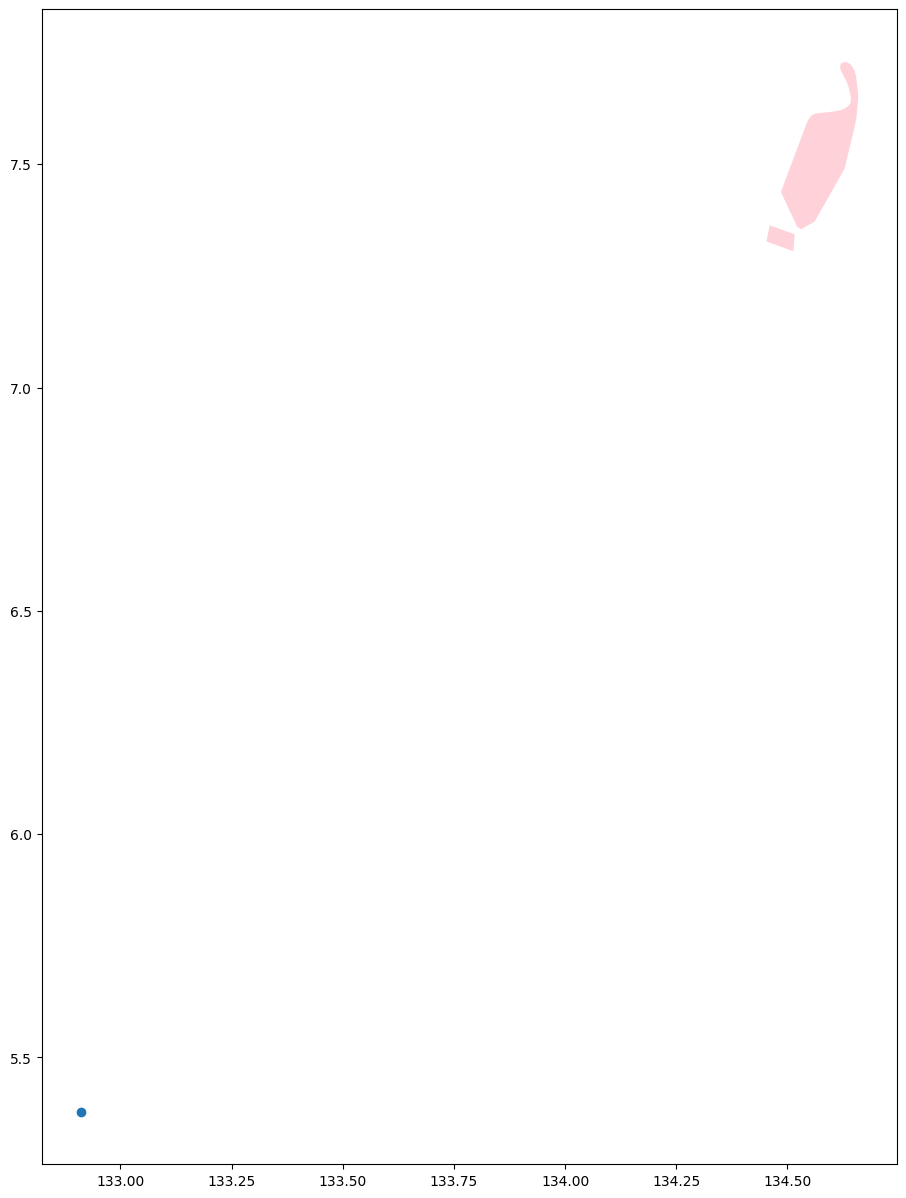

In [103]:
fig, ax = plt.subplots(figsize=(15, 15))

subset = gdf.loc[(gdf['Countries']=="")] 
globe_subset = world.loc[(world["COUNTRY"] == "Palau")]
globe_subset.plot(ax=ax, alpha=0.7, color="pink")
subset.plot(ax=ax)

In [79]:
from shapely.geometry import Point
# apply Shapely POint to turn tuples into coordinates
geom['Coordinates'] = geom['geometry'].apply(lambda x: Point(x))
# Create a geodataframe
gdf = gpd.GeoDataFrame(geom, geometry="Coordinates")
gdf = gdf.set_crs('epsg:4326')

In [88]:
pd.set_option('display.max_rows', 500)

In [104]:
globeshps = world.sjoin(gdf, how="left", predicate='contains').reset_index(drop = True).drop(columns = "geometry_right")

In [129]:
globeshps

,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry_left,index_right,Countries
0,1,Afghanistan,AF,Afghanistan,AF,50.803210,62.566714,"POLYGON ((61.27655 35.60725, 61.29638 35.62854...",30.0,Afghanistan
1,2,Albania,AL,Albania,AL,9.625038,3.073540,"POLYGON ((19.57083 41.68527, 19.58195 41.69569...",135.0,Albania
2,3,Algeria,DZ,Algeria,DZ,70.540082,213.513461,"POLYGON ((4.60335 36.88791, 4.63555 36.88638, ...",26.0,Algeria
3,4,American Samoa,AS,United States,US,0.600124,0.013720,"POLYGON ((-170.74390 -14.37555, -170.74942 -14...",NaN,NaN
4,5,Andorra,AD,Andorra,AD,0.937352,0.055585,"POLYGON ((1.44584 42.60194, 1.48653 42.65042, ...",NaN,NaN
5,6,Angola,AO,Angola,AO,58.873470,103.813059,"MULTIPOLYGON (((23.47611 -17.62584, 23.28916 -...",136.0,Angola
6,7,Anguilla,AI,United Kingdom,GB,0.468389,0.007798,"POLYGON ((-63.16778 18.16445, -63.15695 18.177...",NaN,NaN
7,8,Antarctica,AQ,NaN,NaN,1564.144143,5672.928286,"MULTIPOLYGON (((-179.99999 -84.30535, -179.931...",NaN,NaN
8,9,Antigua and Barbuda,AG,Antigua and Barbuda,AG,1.162901,0.045626,"MULTIPOLYGON (((-61.73806 16.98972, -61.82917 ...",NaN,NaN
9,10,Argentina,AR,Argentina,AR,138.751348,278.308965,"MULTIPOLYGON (((-71.85916 -41.01128, -71.83806...",95.0,Argentina


In [120]:
gpe['Countries'].sort_values(ascending=True).unique()

array(['afghanistan', 'albania', 'algeria', 'angola', 'argentina',
       'armenia', 'aruba', 'australia', 'austria', 'azerbaijan',
       'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus',
       'belgium', 'benin', 'bhutan', 'bolivia', 'botswana', 'brazil',
       'brunei', 'bulgaria', 'cambodia', 'cameroon', 'canada', 'chad',
       'chile', 'china', 'colombia', 'costa rica', 'croatia', 'cuba',
       'denmark', 'djibouti', 'dominica', 'dominican republic',
       'east timor', 'ecuador', 'egypt', 'el salvador', 'eritrea',
       'estonia', 'ethiopia', 'fiji', 'finland', 'france', 'gabon',
       'gambia', 'georgia', 'germany', 'ghana', 'gibraltar', 'greece',
       'grenada', 'guam', 'guatemala', 'guernsey', 'guinea', 'guyana',
       'haiti', 'honduras', 'hong kong', 'hungary', 'iceland', 'india',
       'indonesia', 'iran', 'iraq', 'ireland', 'israel', 'italy',
       'ivory coast', 'jamaica', 'japan', 'jersey', 'jordan',
       'kazakhstan', 'kenya', 'kosovo', 'kuwait', 

In [123]:
len(gpe["Countries"].unique())

166

In [126]:
pd.merge(gpe, globeshps, left_on=gpe["Countries"], right_on=globeshps["COUNTRY"].str.lower(), how="left")['Countries_y'].sort_values(ascending=True).unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Aruba, Netherlands', 'Australia', 'Austria',
       'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil',
       'Bulgaria', 'Cambodia', 'Cameroon', 'Canada', 'Chad', 'Chile',
       'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Eritrea',
       'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia',
       'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Grenada',
       'Guam, United States of America', 'Guatemala',
       'Guernsey, Channel Islands', 'Guinea', 'Guyana', 'Haiti',
       'Honduras', 'Hong Kong, China', 'Hungary', 'Iceland', 'India',
       'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Jersey, Channel Islands', 'Jordan', 'Kazakhstan', 'Kenya',
       'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'L

In [45]:
geospecies.loc[geospecies['geometry'].isnull()]['Countries_x'].unique()

array(['palau', 'bahamas', 'hong kong', 'macao', 'dominica', 'aruba',
       'puerto rico', 'lebanon', 'montenegro', 'kosovo', 'guam', 'malta',
       'ivory coast', 'jordan', 'gambia', 'swaziland', 'guernsey',
       'macedonia'], dtype=object)

In [5]:
world_gpe = world.sjoin(gdf, how="inner", predicate='contains').reset_index(drop = True)

df = (world_gpe.groupby(['COUNTRY','FID'])
      .agg({'sci_name': lambda x: x.tolist(),'txt_mentions':'sum','article_co':'sum'})
      .rename({'txt_mentions' : 'Sum_txt_mentns','article_co' : 'Sum_articles'},axis=1)
      .reset_index())

df['species_num'] = df['sci_name'].str.len()

sample_map = df.merge(world, on = 'FID', how = 'left')
geosample = gpd.GeoDataFrame(sample_map, geometry='geometry')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


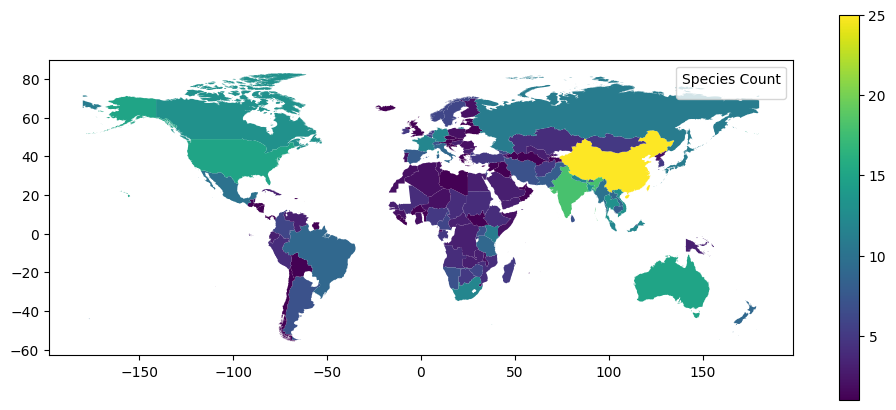

In [65]:
# Sample map

geosample.plot(geosample['species_num'], legend = True, figsize = (12,5), )

legend = plt.legend(title="Species Count", loc = )

In [29]:
from bokeh.palettes import Category20
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
# pip install bokeh

#p = figure(title="What countries are mentioned most often in articles about each species",
          #toolbar_location=None, width=600, height=400)

#source = ColumnDataSource(data=world_gpe)

#for df, color in zip([world_gpe], Category20):
    #print(len(df['sci_name'].unique()))
    
    #p.plot(df['geometry'], color=color, alpha=0.8, legend_label=df['sci_name'].unique())
    
def getPolyCoords(row, geom, coord_type):
    if coord_type == 'x':
        return list(row[geom].exterior.coords.xy[0])
    elif coord_type == 'y':
        return list(row[geom].exterior.coords.xy[1])
    
gdf = geosample.copy()    
gdf['x'] = gdf.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
gdf['y'] = gdf.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = gdf.drop('geometry', axis = 1).copy()
p = figure(title = "A map from Shapefile", plot_width = 800)
p.patches('x', 'y', source = ColumnDataSource(p_df), line_color = "white", line_width = 0.5)
show(p)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [11]:
# Create a world map to show distributions of users 
# NOT A GOOD VISUALIZATION need to demonstrate size according to species count value
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
#empty map
world_map= folium.Map(tiles="cartodbpositron")
#m = MarkerCluster().add_to(world_map)
features = {}
for row in pd.unique(gdf["scientific_name"]):
    features[row] = folium.FeatureGroup(name=row)
#for each coordinate, create circlemarker of user percent
for i in range(len(gdf)):
    lat = gdf.iloc[i]['Coordinates'].x
    long = gdf.iloc[i]['Coordinates'].y
    radius=float(gdf.iloc[i]['Country_count'])*4000
    popup_text = """Country : {}<br>
                Species : {}<br>"""
    popup_text = popup_text.format(gdf.iloc[i]['Countries'],
                                gdf.iloc[i]['scientific_name'])
    folium.Circle(location = [lat, long], radius = radius, popup= popup_text, fill =True).add_to(world_map)
#show the map
world_map

In [44]:
# Drop the tuples columnn, rename the shapely column, set the crs and reset the geometry column
gdf.drop(columns = 'geometry', inplace = True)

In [45]:
import fiona 
gdf.to_file('Geo_tags_test.shp')

/tmp/ipykernel_44/1482716497.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('Geo_tags_test.shp')
